In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.inspection import permutation_importance
import xgboost as xgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
pitch_data = pd.read_csv('PitchData/PitchData.csv')

In [ ]:
pitch_data['Is_StrikeSwinging'] = pitch_data['Pitch_Outcome'].apply(lambda x: True if x == 'StrikeSwinging' else False)
pitch_data['Is_StrikeSwinging'] = pitch_data['Is_StrikeSwinging'].astype(int)

# Modeling of Swing and Misses on Curveballs

In [ ]:
curveball_data = pitch_data.query('Pitch_Type == "Curveball"').dropna()

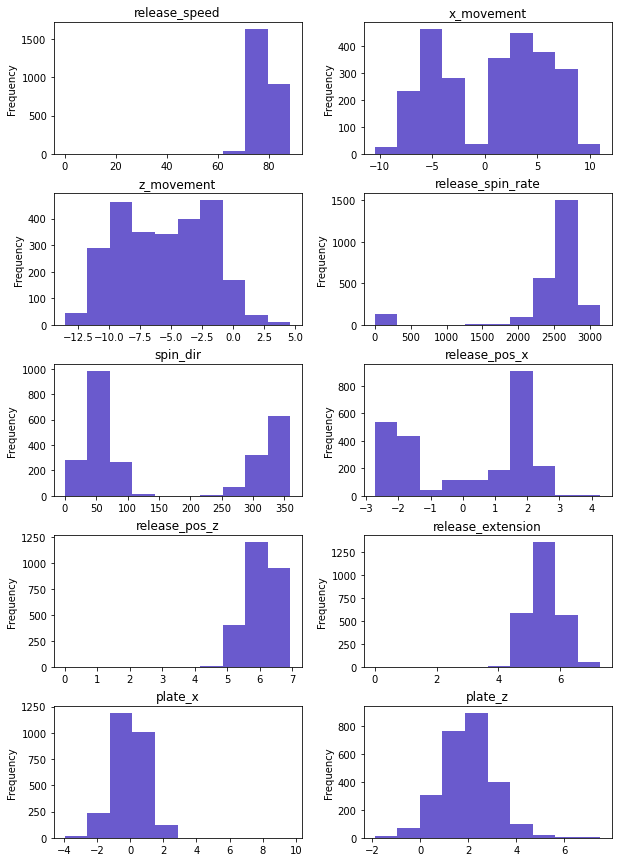

In [ ]:
rsm.distr_plot(curveball_data.loc[:, 'release_speed': 'plate_z'])

Before we start modeling we want to take a look at the data. As you can see from the distribution plots, most of them are relatively normal, with the exceptions of spin_dir, release_pos_x, x_movement.  This is likely due handedness of a pitcher. Let us filter out only one handedness and take a look at the results.

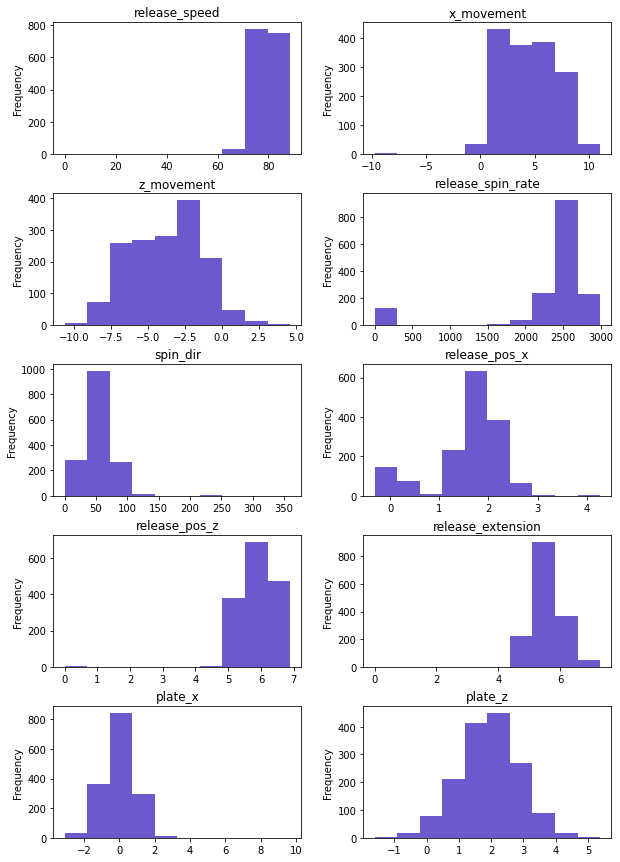

In [ ]:
rsm.distr_plot(curveball_data.query('Pitcher_Throws == "R"').loc[:, 'release_speed': 'plate_z'])

We can see that the three distributions that were not normal are now relatively normal and the ranges and distributions for the other cateogories have stayed the same. This confirms out intial thoughts about the handedness affecting distribtions and will go ahead and create our first model filtering out a single handedness (Right Handed so we have a larger sample size).


In [ ]:
cureveball_R = curveball_data.query('Pitcher_Throws == "R"').loc[:, 'release_speed': 'plate_z']
cureveball_R['Is_StrikeSwinging'] = curveball_data['Is_StrikeSwinging'].astype(int)

In [ ]:
# Creating training and test sets for our intial modeling
x_train, x_test, y_train, y_test = train_test_split(cureveball_R.loc[:, 'release_speed': 'plate_z'], cureveball_R.loc[:, 'Is_StrikeSwinging'])

In [ ]:
# Creating Evaluative Variables for model
evar = ['release_speed',
        'x_movement',
        'z_movement',
        'release_spin_rate',
        'spin_dir',
        'release_pos_x',
        'release_pos_z',
        'release_extension',
        'plate_x',
        'plate_z'
        ]

In [ ]:
# First Model with all columns
x_train_1 = x_train[evar].copy()
x_train_1['Is_StrikeSwinging'] = y_train.copy()
form = "Is_StrikeSwinging ~ " + " + ".join(evar)

logit_model_all = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    data=x_train_1
)
print(rsm.vif(logit_model_all))
logit_model_all = logit_model_all.fit()
rsm.or_ci(logit_model_all)

            variable    vif    Rsq
0         z_movement  3.213  0.689
1      release_pos_z  2.422  0.587
2      release_speed  2.343  0.573
3           spin_dir  2.226  0.551
4         x_movement  1.785  0.440
5            plate_x  1.523  0.343
6      release_pos_x  1.406  0.289
7  release_extension  1.384  0.277
8  release_spin_rate  1.377  0.274
9            plate_z  1.377  0.274


,index,OR,OR%,2.5%,97.5%,p.values,
1,release_speed,1.088,8.8%,1.026,1.154,0.005,**
2,x_movement,1.009,0.9%,0.889,1.146,0.889,
3,z_movement,1.030,3.0%,0.867,1.223,0.74,
4,release_spin_rate,1.000,0.0%,1.000,1.000,0.292,
5,spin_dir,0.990,-1.0%,0.973,1.008,0.279,
6,release_pos_x,0.943,-5.7%,0.680,1.306,0.723,
7,release_pos_z,0.458,-54.2%,0.279,0.751,0.002,**
8,release_extension,0.792,-20.8%,0.501,1.252,0.319,
9,plate_x,0.714,-28.6%,0.546,0.933,0.014,*
10,plate_z,0.708,-29.2%,0.559,0.896,0.004,**


- First we run a logistic regression model with all the columns
- We also have a good amount of insignificant amount of predictors, however we do not want to just throw out all insignificant variables. Just the ones we know for sure will be not strong based on intuition and the p-values
- Also, our VIF values look strong as there does not appear to be any multicollinearity
- From looking at our odds-ratio results, the predictors that stick out to me are release_extension, spin_dir, and x_movement
    - Most curveballs are going to spin in similar directions, so the slight difference in direction does not appear to be significant
    - release_extension is usually a much better indicator for fastball effectiveness, as the purpose of curveballs are usually to throw off timings and the movement, rather than how much closer the pitcher's arm is to homeplate
    - x_movement seems like it would not be a great predictor as many curveball's effectiveness is on their vertical movement, however, it seems close minded to remove predictors that are related to the balls movement to the plate, we will keep this for now

In [ ]:
evar = ['release_speed',
        'x_movement',
        'z_movement',
        'release_spin_rate',
#         'spin_dir',
        'release_pos_x',
        'release_pos_z',
#         'release_extension',
        'plate_x',
        'plate_z'
        ]

In [ ]:
# 2nd Model without spin_dir and release_extension

x_train_2 = x_train[evar].copy()
x_train_2['Is_StrikeSwinging'] = y_train.copy()
form = "Is_StrikeSwinging ~ " + " + ".join(evar)
logit_model_2 = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    data=x_train_2
)
print(rsm.vif(logit_model_2))
logit_model_2 = logit_model_2.fit()
rsm.or_ci(logit_model_2)

            variable    vif    Rsq
0      release_pos_z  2.163  0.538
1      release_speed  1.878  0.467
2         z_movement  1.608  0.378
3            plate_x  1.506  0.336
4  release_spin_rate  1.368  0.269
5            plate_z  1.359  0.264
6         x_movement  1.355  0.262
7      release_pos_x  1.346  0.257


,index,OR,OR%,2.5%,97.5%,p.values,
1,release_speed,1.072,7.2%,1.011,1.136,0.02,*
2,x_movement,0.979,-2.1%,0.893,1.072,0.641,
3,z_movement,0.974,-2.6%,0.884,1.073,0.598,
4,release_spin_rate,1.000,0.0%,1.000,1.001,0.246,
5,release_pos_x,0.952,-4.8%,0.692,1.308,0.76,
6,release_pos_z,0.506,-49.4%,0.314,0.816,0.005,**
7,plate_x,0.732,-26.8%,0.565,0.949,0.019,*
8,plate_z,0.690,-31.0%,0.548,0.868,0.002,**


- With our new model, we have the same amount of significant predictors
- Some of the predictors' p-values went down such as
    - release_speed
    - release_spin_rate
- Others such as x_movement, z_movement, and release_pos_x went up
- Our data could be being limited by the small sample size, so lets add back in the lefties and look at the results
- For this next model we are going to omit spin_dir and release_extension still

In [ ]:
# Using both lefties and righties
x_train, x_test, y_train, y_test = train_test_split(curveball_data.loc[:, 'release_speed': 'plate_z'], curveball_data.loc[:, 'Is_StrikeSwinging'])

In [ ]:
evar = ['release_speed',
        'x_movement',
        'z_movement',
        'release_spin_rate',
#         'spin_dir',
        'release_pos_x',
        'release_pos_z',
#         'release_extension',
        'plate_x',
        'plate_z'
        ]

In [ ]:
# Same model as before, but with the lefties added in
x_train_3 = x_train[evar].copy()
x_train_3['Is_StrikeSwinging'] = y_train.copy()
form = "Is_StrikeSwinging ~ " + " + ".join(evar)
logit_model_3 = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    data=x_train_3
)

print(rsm.vif(logit_model_3))
logit_model_3 = logit_model_3.fit()
logit_model_3.summary()
rsm.or_ci(logit_model_3)

            variable    vif    Rsq
0      release_pos_x  4.723  0.788
1         x_movement  4.102  0.756
2         z_movement  2.264  0.558
3      release_pos_z  1.780  0.438
4      release_speed  1.646  0.393
5  release_spin_rate  1.236  0.191
6            plate_z  1.048  0.046
7            plate_x  1.023  0.023


,index,OR,OR%,2.5%,97.5%,p.values,
1,release_speed,1.050,5.0%,1.003,1.100,0.037,*
2,x_movement,0.950,-5.0%,0.895,1.009,0.095,.
3,z_movement,0.942,-5.8%,0.886,1.002,0.057,.
4,release_spin_rate,1.000,0.0%,1.000,1.001,0.034,*
5,release_pos_x,1.045,4.5%,0.876,1.246,0.627,
6,release_pos_z,0.446,-55.4%,0.307,0.649,< .001,***
7,plate_x,0.849,-15.1%,0.727,0.992,0.04,*
8,plate_z,0.604,-39.6%,0.524,0.697,< .001,***


- Now we are getting more significant predictors
- However, now when we look at our VIF results, we see there is some multicollinearity, so for our next model we will remove release_pos_x, as it mostly likely is correlated with x_movement

In [ ]:
evar = ['release_speed',
        'x_movement',
        'z_movement',
        'release_spin_rate',
#         'spin_dir',
#         'release_pos_x',
        'release_pos_z',
#         'release_extension',
        'plate_x',
        'plate_z'
        ]

In [ ]:
# Model that also excludes release_pos_x

x_train_4 = x_train[evar].copy()
x_train_4['Is_StrikeSwinging'] = y_train.copy()
form = "Is_StrikeSwinging ~ " + " + ".join(evar)
logit_model_4 = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    data=x_train_4
)

print(rsm.vif(logit_model_4))
logit_model_4 = logit_model_4.fit()
logit_model_4.summary()
rsm.or_ci(logit_model_4)

            variable    vif    Rsq
0         z_movement  2.236  0.553
1      release_pos_z  1.681  0.405
2      release_speed  1.561  0.359
3         x_movement  1.367  0.269
4  release_spin_rate  1.236  0.191
5            plate_z  1.044  0.042
6            plate_x  1.022  0.022


,index,OR,OR%,2.5%,97.5%,p.values,
1,release_speed,1.053,5.3%,1.006,1.101,0.026,*
2,x_movement,0.962,-3.8%,0.929,0.996,0.028,*
3,z_movement,0.944,-5.6%,0.888,1.003,0.062,.
4,release_spin_rate,1.000,0.0%,1.000,1.001,0.035,*
5,release_pos_z,0.436,-56.4%,0.304,0.626,< .001,***
6,plate_x,0.848,-15.2%,0.726,0.991,0.038,*
7,plate_z,0.605,-39.5%,0.525,0.698,< .001,***


- This appears to be our best logistic regression model
    - The most amount of significant predictors
    - No multicollinearity present
- Now we will test our logit model and look at its prediction effectiveness

In [ ]:
x_test_logit = x_test.copy()
x_test_logit = x_test_logit.assign(StrikeSwing_logit = logit_model_4.predict(x_test_logit))
x_test_logit['Is_StrikeSwinging'] = y_test
x_test_logit['Pred_Swing'] = x_test_logit['StrikeSwing_logit'] > x_test_logit.Is_StrikeSwinging.value_counts()[1] / x_test_logit.Is_StrikeSwinging.value_counts()[0]
x_test_logit['Pred_Swing'] = x_test_logit['Pred_Swing'].astype(int)

## XGBoost Modeling
- XGBoost Modeling may appear to be overkill for a dataset of this size, but we proceeding as if this were the complete set of data. Which would be significantly larger
- Thus XGBoost serves as a great model to use

In [ ]:
evar = ['release_speed',
        'x_movement',
        'z_movement',
        'release_spin_rate',
        'spin_dir',
        'release_pos_x',
        'release_pos_z',
        'release_extension',
        'plate_x',
        'plate_z'
        ]
x_train_xgb = x_train[evar].copy()

In [ ]:
# Grid Search XGBoost Modeling
clf = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    objective="binary:logistic",
    use_label_encoder=False,
    # early_stopping_rounds=10,
    eval_metric="auc",
    random_state=1234,
).fit(x_train, y_train.values, verbose=True)

clf = xgb.XGBClassifier()
param_grid = {
    "max_depth": list(range(1, 3)),
    "n_estimators": list(range(100, 301, 100)),
}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=3, n_jobs=3, refit="AUC", verbose=5
).fit(x_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[01:43:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
x_test_xgb = x_test.copy()
x_test_xgb['xgb_pred']=clf_cv.best_estimator_.predict_proba(x_test_xgb)[:, 1]
x_test_xgb['Is_StrikeSwinging'] = y_test.copy()
x_test_xgb['Pred_Swing_xgb'] = x_test_xgb['xgb_pred'] > x_test_xgb.Is_StrikeSwinging.value_counts()[1] / x_test_xgb.Is_StrikeSwinging.value_counts()[0]
x_test_xgb['Pred_Swing_xgb'] = x_test_xgb['Pred_Swing_xgb'].astype(int)

In [ ]:
rsm.evalbin(x_test_logit, 'Is_StrikeSwinging', 1, 'Pred_Swing')[['TP', 'FP', 'TN','FN', 'total', 'TPR', 'TNR']]

,TP,FP,TN,FN,total,TPR,TNR
0,40,155,414,35,644,0.533,0.728


In [ ]:
rsm.evalbin(x_test_xgb, 'Is_StrikeSwinging', 1, 'Pred_Swing_xgb')[['TP', 'FP', 'TN','FN', 'total', 'TPR', 'TNR']]

,TP,FP,TN,FN,total,TPR,TNR
0,50,168,401,25,644,0.667,0.705


### Comparing Results between Logistic Regression Model and XGBoost model
- By looking at both models' confusion matrix results, we can see that the XGBoost model performed stronger in the True Positive Rate and comparably with the True Negative Rate
- However, these results are not very indicative of true effectiveness as we do have a small sample size
- If we were to evaluate and make conclusions based on a complete set of data, we would most likely see XGBoost perform significantly better as it can handle larger datasets more proficiently
- Furthermore, we only used 3 folds for the cross validation and used very conservative parameters for the purposes of this exercise
    - With more data and computing power I believe it would be an even more effective model without becoming overfit to the training data.

# Most Important Characteristics of a Curveball

In [ ]:
def importance(clf, X, y, cn):
    imp = permutation_importance(
        clf, X, y, scoring="roc_auc", n_repeats=10, random_state=1234
    )
    data = pd.DataFrame(imp.importances.T)
    if cn is not None:
        data.columns = cn
    order = data.agg("mean").sort_values(ascending=False).index
    fig = sns.barplot(
        x="value", y="variable", color="slateblue", data=pd.melt(data[order])
    )
    fig.set(title="Permutation Importances", xlabel=None, ylabel=None)
    return fig

In [ ]:
x_train_perm = x_train.copy()
y_train_perm = y_train.copy()
x_train_cols = x_train.columns
clf = xgb.XGBClassifier(
    max_depth=2,
    n_estimators=500,
    objective="binary:logistic",
    use_label_encoder=False,
    # early_stopping_rounds=10,
    eval_metric="auc",
    random_state=1234,
).fit(x_train_perm, y_train_perm.values, verbose=True)

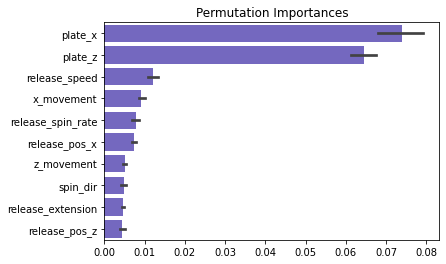

In [ ]:
fig = importance(clf, x_train_perm, y_train_perm, x_train_cols)

- Using our XGBoost model, I was able to create a Permutation Importance chart of each relative column
- Looking at the graph, the two most important characteristics are where the ball crosses home plate.
- With velocity and spin rate also being in the top five (Sticky Stuff!)
- Our initial thoughts are also confirmed with spin_dir and release_extension being part of least important predictors.